In [2]:
# Install required libraries
!pip install yfinance timesfm

In [3]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3faed5e2753d018e1040909954ea3d324b81bae10dc133251bb878c77ff431f7
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [4]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [17]:
import pandas as pd
import ta


start_date = "2022-10-12"
end_date = "2024-01-01"
analysis_start_date = "2023-01-01"  # تاریخ شروع مورد نظر

# دانلود داده‌های سهام از فایل
df = pd.read_csv('/content/خودرو.csv')

# Ensure the 'date' column is parsed as datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filter the DataFrame by the date range
data = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Set 'date' column as index and ensure it's datetime
data.set_index('date', inplace=True)

# محاسبه میانگین‌های متحرک و اندیکاتورهای تکنیکال
data['moving_avg_10'] = data['close'].rolling(window=10).mean()
data['moving_avg_50'] = data['close'].rolling(window=50).mean()
data['rsi'] = ta.momentum.RSIIndicator(data['close'], window=14).rsi()
data['ema'] = ta.trend.EMAIndicator(data['close'], window=10).ema_indicator()

# حذف سطرهایی که دارای مقادیر NaN هستند (به دلیل محاسبات میانگین‌های متحرک)
data.dropna(inplace=True)

# فیلتر کردن داده‌ها از تاریخ شروع مورد نظر
analysis_start_date = pd.to_datetime(analysis_start_date)  # Convert to datetime
data = data[data.index >= analysis_start_date]

# تنظیم DataFrame نهایی
df_final = data[['close', 'volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']].reset_index()
df_final.columns = ['date', 'close', 'volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']
df_final['date'] = pd.to_datetime(df_final['date'])
df_final.set_index('date', inplace=True)

# نمایش داده‌ها
df=df_final


<ipython-input-17-9d3986bdb422>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['moving_avg_10'] = data['close'].rolling(window=10).mean()
<ipython-input-17-9d3986bdb422>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['moving_avg_50'] = data['close'].rolling(window=50).mean()
<ipython-input-17-9d3986bdb422>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [18]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["volume"].append(df["volume"][start:context_end].tolist() + [df["volume"].iloc[context_end - 1]])
        examples["moving_avg_10"].append(df["moving_avg_10"][start:context_end].tolist() + [df["moving_avg_10"].iloc[context_end - 1]])
        examples["moving_avg_50"].append(df["moving_avg_50"][start:context_end].tolist() + [df["moving_avg_50"].iloc[context_end - 1]])
        examples["rsi"].append(df["rsi"][start:context_end].tolist() + [df["rsi"].iloc[context_end - 1]])
        examples["ema"].append(df["ema"][start:context_end].tolist() + [df["ema"].iloc[context_end - 1]])
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [13]:


# Define metrics
def mse(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.square(y_pred - y_true), axis=1, keepdims=True)

def mae(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs(y_pred - y_true), axis=1, keepdims=True)

In [14]:
import timesfm

context_len = 64
batch_size = 1  # ثابت نگه‌داشتن batch size
horizon_len = 1  # ثابت نگه‌داشتن horizon length



In [15]:

    model = timesfm.TimesFm(
        context_len=context_len,
        horizon_len=horizon_len,
        input_patch_len=32,
        output_patch_len=128,
        num_layers=20,
        model_dims=1280,
        backend="gpu",
    )
    model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 4.25 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.50 seconds.
Jitting decoding.
Jitted decoding in 25.43 seconds.


In [34]:
import os
import time
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import timesfm
import ta
from itertools import combinations
import gc
import json



features = ["volume", "moving_avg_10", "moving_avg_50", "rsi", "ema"]
feature_combinations = []
for r in range(1, len(features) + 1):
    feature_combinations.extend(combinations(features, r))
results_by_cov = []

for combo in feature_combinations:
    print(f"Processing combo: {combo}")
    input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=1)
    metrics = defaultdict(list)


    # Process in smaller sub-batches
    for i, example in enumerate(input_data()):
        dynamic_numerical_covariates = {feature: example[feature] for feature in combo}
        raw_forecast, _ = model.forecast(
                            inputs=example["inputs"], freq=[0] * len(example["inputs"])
                        )
        cov_forecast, ols_forecast = model.forecast_with_covariates(
           inputs=example["inputs"],
           dynamic_numerical_covariates=dynamic_numerical_covariates,
           dynamic_categorical_covariates={},
           static_numerical_covariates={},
           static_categorical_covariates={},
           freq=[0] * len(example["inputs"]),
           normalize_xreg_target_per_input=True,
           xreg_mode="timesfm + xreg",)


        for j in range(len(example["inputs"])):
            result = {
                'input_index': j,
                'train_start_date': str(example["dates"][j][0]),
                'train_end_date': str(example["dates"][j][-2]),
                'predict_date': str(example["dates"][j][-1]),
                'raw_forecast': raw_forecast[j][0],
                'y_predict' : cov_forecast[j][0],
                'y_actual': example["outputs"][j][0],
                'batch_size': batch_size,
                'context_len': context_len,
                "timesfm + xreg":"timesfm + xreg",
                'combo' : combo,

            }
            results_by_cov.append(result)


Processing combo: ('volume',)
Processing combo: ('moving_avg_10',)
Processing combo: ('moving_avg_50',)
Processing combo: ('rsi',)
Processing combo: ('ema',)
Processing combo: ('volume', 'moving_avg_10')
Processing combo: ('volume', 'moving_avg_50')
Processing combo: ('volume', 'rsi')
Processing combo: ('volume', 'ema')
Processing combo: ('moving_avg_10', 'moving_avg_50')
Processing combo: ('moving_avg_10', 'rsi')
Processing combo: ('moving_avg_10', 'ema')
Processing combo: ('moving_avg_50', 'rsi')
Processing combo: ('moving_avg_50', 'ema')
Processing combo: ('rsi', 'ema')
Processing combo: ('volume', 'moving_avg_10', 'moving_avg_50')
Processing combo: ('volume', 'moving_avg_10', 'rsi')
Processing combo: ('volume', 'moving_avg_10', 'ema')
Processing combo: ('volume', 'moving_avg_50', 'rsi')
Processing combo: ('volume', 'moving_avg_50', 'ema')
Processing combo: ('volume', 'rsi', 'ema')
Processing combo: ('moving_avg_10', 'moving_avg_50', 'rsi')
Processing combo: ('moving_avg_10', 'movin

In [35]:
 results_df = pd.DataFrame(results_by_cov)
 results_df

,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_predict,y_actual,batch_size,context_len,timesfm + xreg,combo
0,0,2023-01-01 00:00:00,2023-05-03 00:00:00,2023-05-06 00:00:00,4236.040527,5813.373535,4417.0,1,64,timesfm + xreg,"(volume,)"
1,0,2023-01-02 00:00:00,2023-05-06 00:00:00,2023-05-07 00:00:00,4427.861328,5144.402832,4197.0,1,64,timesfm + xreg,"(volume,)"
2,0,2023-01-03 00:00:00,2023-05-07 00:00:00,2023-05-08 00:00:00,4261.471191,5264.926270,4129.0,1,64,timesfm + xreg,"(volume,)"
3,0,2023-01-04 00:00:00,2023-05-08 00:00:00,2023-05-09 00:00:00,4190.154297,4803.318359,4041.0,1,64,timesfm + xreg,"(volume,)"
4,0,2023-01-07 00:00:00,2023-05-09 00:00:00,2023-05-10 00:00:00,4105.551270,5277.626953,3782.0,1,64,timesfm + xreg,"(volume,)"
...,...,...,...,...,...,...,...,...,...,...,...
4800,0,2023-09-23 00:00:00,2023-12-24 00:00:00,2023-12-25 00:00:00,2767.093018,2868.526123,2755.0,1,64,timesfm + xreg,"(volume, moving_avg_10, moving_avg_50, rsi, ema)"
4801,0,2023-09-25 00:00:00,2023-12-25 00:00:00,2023-12-26 00:00:00,2749.614746,2896.989990,2718.0,1,64,timesfm + xreg,"(volume, moving_avg_10, moving_avg_50, rsi, ema)"
4802,0,2023-09-26 00:00:00,2023-12-26 00:00:00,2023-12-27 00:00:00,2707.894287,2777.641357,2732.0,1,64,timesfm + xreg,"(volume, moving_avg_10, moving_avg_50, rsi, ema)"
4803,0,2023-09-27 00:00:00,2023-12-27 00:00:00,2023-12-30 00:00:00,2713.052002,2803.293457,2736.0,1,64,timesfm + xreg,"(volume, moving_avg_10, moving_avg_50, rsi, ema)"


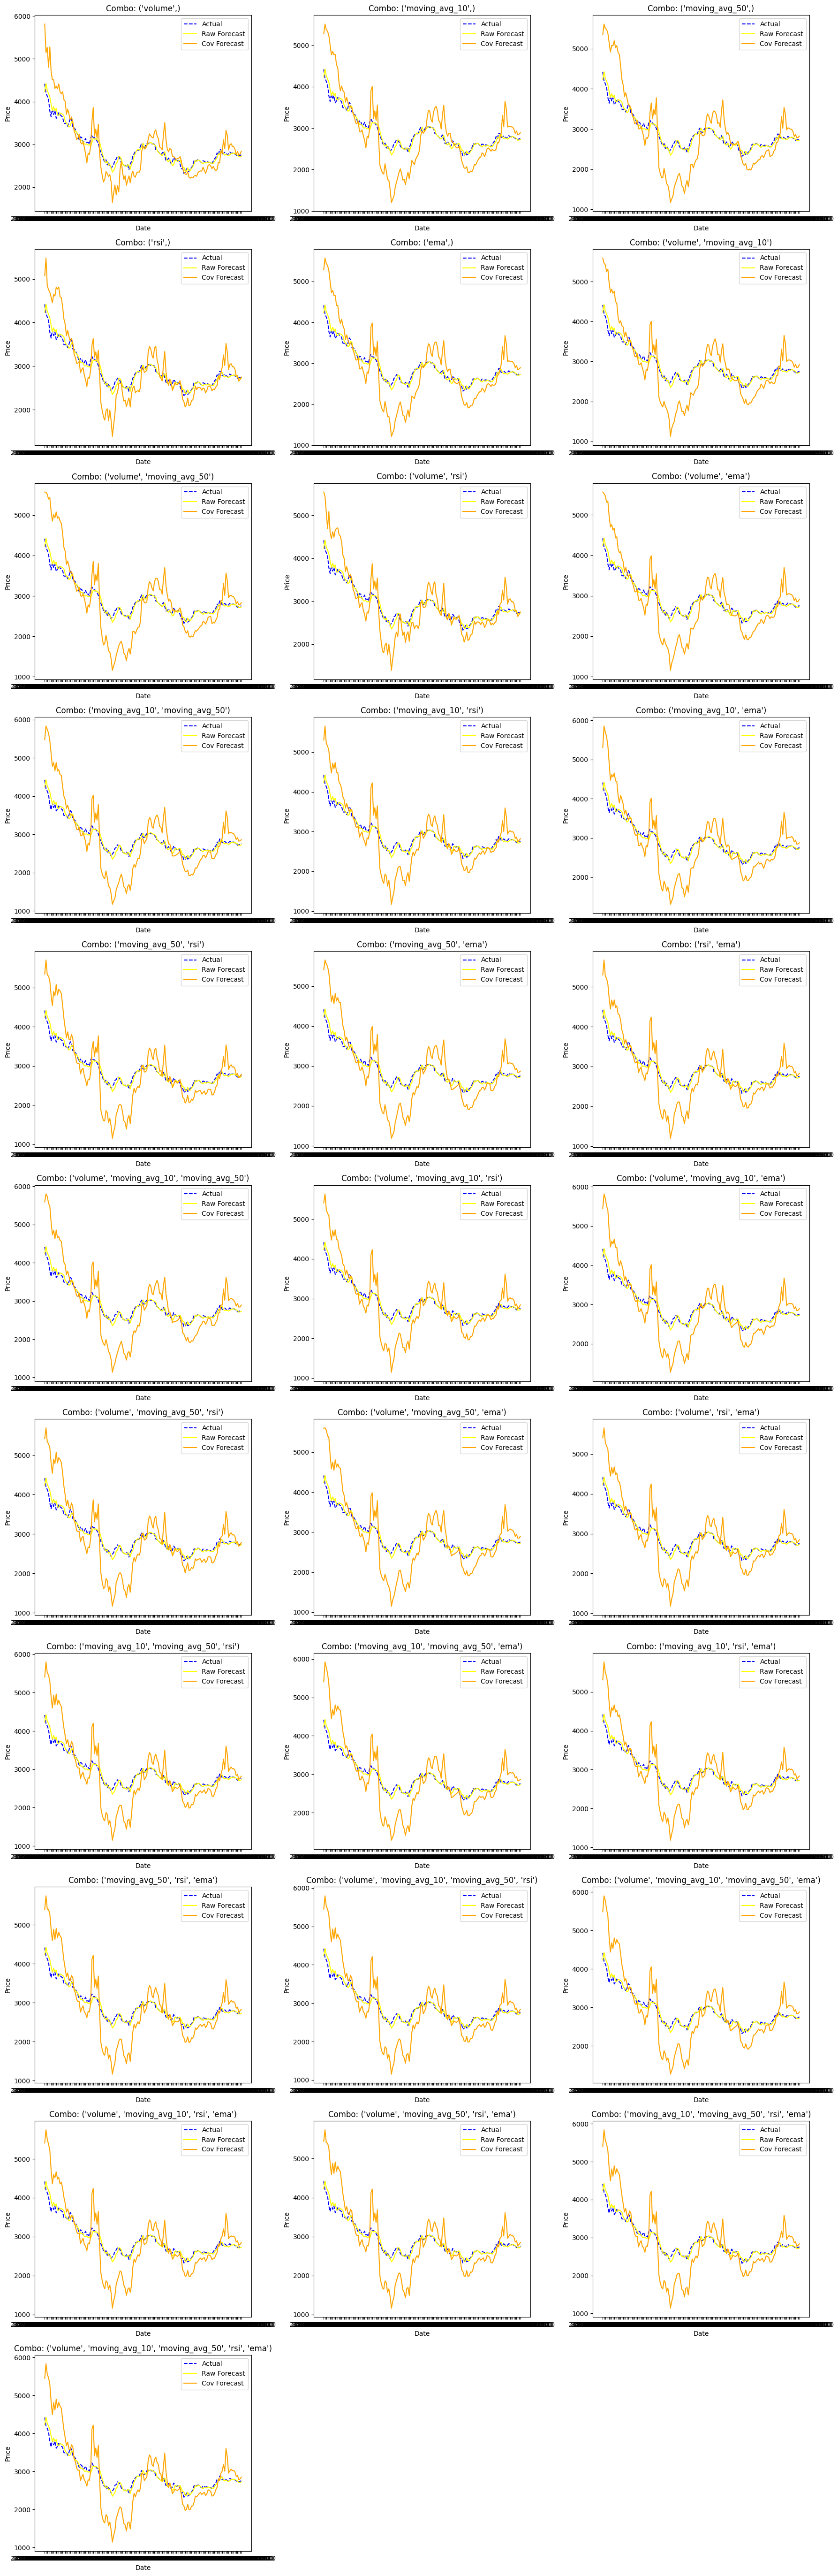

In [36]:
import math

# تعداد سطرها و ستون‌ها برای نمودارها
num_columns = 3
num_combos = len(feature_combinations)
num_rows = math.ceil(num_combos / num_columns)

# ایجاد نمودارهای چندگانه
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, 5 * num_rows))

# تبدیل axes به یک لیست مسطح برای دسترسی آسان
axes = axes.flatten()

for idx, combo in enumerate(feature_combinations):
    combo_results = results_df[results_df['combo'] == combo]

    axes[idx].plot(combo_results['predict_date'], combo_results['y_actual'], label='Actual', color='blue', linestyle='--')
    axes[idx].plot(combo_results['predict_date'], combo_results['raw_forecast'], label='Raw Forecast', color='yellow')
    axes[idx].plot(combo_results['predict_date'], combo_results['y_predict'], label='Cov Forecast', color='orange')

    axes[idx].set_title(f'Combo: {combo}')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Price')
    axes[idx].legend()

# حذف هر subplot خالی
for ax in axes[num_combos:]:
    fig.delaxes(ax)

# تنظیم فاصله بین نمودارها
plt.tight_layout()
plt.show()


In [38]:
 initial_investment = 10000000

In [39]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(y_actual, y_forecast):
    return mean_squared_error(y_actual, y_forecast)

# Generalized accuracy function
def calculate_accuracy(y_actual, y_forecast):
    correct_predictions = 0
    total_predictions = 0

    for i in range(1, len(y_actual)):
        actual_today = y_actual.iloc[i]
        predicted_today = y_forecast.iloc[i]
        actual_yesterday = y_actual.iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if actual_movement == 0:
            if predicted_movement != 0:
                total_predictions += 1

        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1
    b=predicted_movement
    return correct_predictions / total_predictions if total_predictions > 0 else 0

# Generalized profit calculation function
def calculate_profit(y_actual, y_forecast):
    capital = initial_investment
    position = 0

    for i in range(1, len(y_actual)):
        today_price = y_actual.iloc[i]
        yesterday_price = y_actual.iloc[i - 1]
        predicted_today_price = y_forecast.iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * y_actual.iloc[-1]

    return capital - initial_investment

# Generalized actual direction accuracy function
def calculate_actual_direction_accuracy(y_actual, y_forecast):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(y_actual)):
        real_directions.append(get_direction(y_actual.iloc[i - 1], y_actual.iloc[i]))
        predicted_directions.append(get_direction(y_actual.iloc[i - 1], y_forecast.iloc[i]))


    return accuracy_score(real_directions, predicted_directions)

# Generalized direction accuracy function
def calculate_direction_accuracy(y_actual, y_forecast):
    correct_predictions = 0
    total_predictions = 0

    for i in range(1, len(y_actual)):
        actual_today = y_actual.iloc[i]
        predicted_today = y_forecast.iloc[i]
        actual_yesterday = y_actual.iloc[i - 1]
        predicted_yesterday = y_forecast.iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - predicted_yesterday
        if actual_movement == 0:
            if predicted_movement != 0:
                total_predictions += 1

        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

# Generalized direction profit calculation function
def calculate_direction_profit(y_actual, y_forecast):
    capital = initial_investment
    position = 0

    for i in range(2, len(y_forecast)):
        yesterday_price = y_actual.iloc[i - 1]
        yesterday_predicted_today_price = y_forecast.iloc[i - 1]
        predicted_today_price = y_forecast.iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * y_actual.iloc[-1]

    return capital - initial_investment

def calculate_results_for_combo(combo, context_results_df_actual, context_results_df_predicted):
    # محاسبه مقادیر متریک‌ها
    mse_value = calculate_mse(context_results_df_actual, context_results_df_predicted)
    accuracy_value = calculate_accuracy(context_results_df_actual, context_results_df_predicted)
    profit = calculate_profit(context_results_df_actual, context_results_df_predicted)
    direction_accuracy = calculate_direction_accuracy(context_results_df_actual, context_results_df_predicted)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df_actual, context_results_df_predicted)
    direction_profit = calculate_direction_profit(context_results_df_actual, context_results_df_predicted)

    # ساخت دیکشنری از نتایج محاسبه شده
    result = {
        'combo': combo,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# حالا نتایج را برای هر combo حساب می‌کنیم
final_results = []

for combo in results_df['combo'].unique():
    combo_data_actual = results_df[results_df['combo'] == combo]['y_actual']
    combo_data_predicted = results_df[results_df['combo'] == combo]['y_predict']

    combo_results_df = calculate_results_for_combo(combo, combo_data_actual, combo_data_predicted)
    final_results.append(combo_results_df)

# ترکیب تمام نتایج در یک DataFrame
final_results_df = pd.concat(final_results).reset_index(drop=True)

# نمایش نتایج نهایی
print(final_results_df)


                                               combo            mse  accuracy  \
0                                          (volume,)  166680.577003  0.487013   
1                                   (moving_avg_10,)  305999.062130  0.493506   
2                                   (moving_avg_50,)  409775.522656  0.474026   
3                                             (rsi,)  183564.812202  0.454545   
4                                             (ema,)  310925.190445  0.487013   
5                            (volume, moving_avg_10)  309224.455362  0.480519   
6                            (volume, moving_avg_50)  397104.495174  0.467532   
7                                      (volume, rsi)  195702.760273  0.435065   
8                                      (volume, ema)  314922.622870  0.474026   
9                     (moving_avg_10, moving_avg_50)  379273.534115  0.467532   
10                              (moving_avg_10, rsi)  258407.997487  0.454545   
11                          

In [40]:

# پیدا کردن بهترین combo‌ها برای هر معیار
best_mse_combo = final_results_df.loc[final_results_df['mse'].idxmin()]
best_accuracy_combo = final_results_df.loc[final_results_df['accuracy'].idxmax()]
best_profit_combo = final_results_df.loc[final_results_df['profit'].idxmax()]
best_direction_accuracy_combo = final_results_df.loc[final_results_df['direction_accuracy'].idxmax()]
best_actual_direction_accuracy_combo = final_results_df.loc[final_results_df['actual_direction_accuracy'].idxmax()]
best_direction_profit_combo = final_results_df.loc[final_results_df['direction_profit'].idxmax()]

# نمایش بهترین ترکیب‌ها برای هر معیار
print("Best Combinations by Metric:")
print(f"Best MSE Combo: {best_mse_combo['combo']} with MSE: {best_mse_combo['mse']}")
print(f"Best Accuracy Combo: {best_accuracy_combo['combo']} with Accuracy: {best_accuracy_combo['accuracy']}")
print(f"Best Profit Combo: {best_profit_combo['combo']} with Profit: {best_profit_combo['profit']}")
print(f"Best Direction Accuracy Combo: {best_direction_accuracy_combo['combo']} with Direction Accuracy: {best_direction_accuracy_combo['direction_accuracy']}")
print(f"Best Actual Direction Accuracy Combo: {best_actual_direction_accuracy_combo['combo']} with Actual Direction Accuracy: {best_actual_direction_accuracy_combo['actual_direction_accuracy']}")
print(f"Best Direction Profit Combo: {best_direction_profit_combo['combo']} with Direction Profit: {best_direction_profit_combo['direction_profit']}")

Best Combinations by Metric:
Best MSE Combo: ('volume',) with MSE: 166680.5770029442
Best Accuracy Combo: ('moving_avg_10',) with Accuracy: 0.4935064935064935
Best Profit Combo: ('moving_avg_10',) with Profit: -3059099.6590029188
Best Direction Accuracy Combo: ('volume', 'moving_avg_10', 'moving_avg_50') with Direction Accuracy: 0.564935064935065
Best Actual Direction Accuracy Combo: ('moving_avg_10',) with Actual Direction Accuracy: 0.4935064935064935
Best Direction Profit Combo: ('moving_avg_10', 'moving_avg_50', 'rsi', 'ema') with Direction Profit: 955545.195005415


In [41]:
# محاسبه‌ی متریک‌ها برای پیش‌بینی خام (Raw Forecast)
results_df=results_df[results_df['combo'] == combo]
y_actual = results_df['y_actual'].values
raw_forecast = results_df['raw_forecast'].values


# محاسبه متریک‌ها با استفاده از توابع از پیش تعریف شده
mse_value = calculate_mse(pd.Series(y_actual), pd.Series(raw_forecast))
accuracy_value = calculate_accuracy(pd.Series(y_actual), pd.Series(raw_forecast))
profit_value = calculate_profit(pd.Series(y_actual), pd.Series(raw_forecast))
direction_accuracy_value = calculate_direction_accuracy(pd.Series(y_actual), pd.Series(raw_forecast))
actual_direction_accuracy_value = calculate_actual_direction_accuracy(pd.Series(y_actual), pd.Series(raw_forecast))
direction_profit_value = calculate_direction_profit(pd.Series(y_actual), pd.Series(raw_forecast))

# نمایش نتایج محاسباتی
print(f"MSE: {mse_value}")
print(f"Accuracy: {accuracy_value}")
print(f"Profit: {profit_value}")
print(f"Direction Accuracy: {direction_accuracy_value}")
print(f"Actual Direction Accuracy: {actual_direction_accuracy_value}")
print(f"Direction Profit: {direction_profit_value}")


MSE: 7163.823384781806
Accuracy: 0.538961038961039
Profit: -1551123.7504239343
Direction Accuracy: 0.5454545454545454
Actual Direction Accuracy: 0.538961038961039
Direction Profit: 469615.5246651992


In [42]:

    initial_price = results_df['y_actual'].iloc[0]
    final_price = results_df['y_actual'].iloc[-1]

    # Calculate the number of shares bought initially
    shares_bought = initial_investment / initial_price

    # Calculate the final value of the investment
    final_investment_value = shares_bought * final_price

    # Calculate the total profit
    buy_and_hold_profit = final_investment_value - initial_investment
    buy_and_hold_profit

-3753678.9676250853